# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_prior_32D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:
# Parameters
# --- Parameters fof Experiment ---
dim_exp = 32  # Dimension (e.g., 2D, 4D, 8D as in the paper)
data_points_exp = 40000 # Example number of data points
iterations_exp_initial = 1 # Iterations for initial training phase
iterations_exp_long = 500000 # Iterations for longer training phase
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 50 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

# === Section ===

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section 4.1.2: L1 Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")

# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: y_j_exp_tensor shape torch.Size([40000, 32]), psi_samples_exp_tensor shape torch.Size([40000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot with L2 Loss for the new experiment ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-4)

# Initial shorter training phase with a higher learning rate
for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

# Longer training phase with a reduced learning rate
for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-4
for i in range(iterations_exp_long):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_concave_quad.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 29702.923828125
iteration 0 loss 18920.41015625


iteration 500 loss 231.5140380859375


iteration 1000 loss 210.7346954345703


iteration 1500 loss 201.6593017578125


iteration 2000 loss 197.1886749267578


iteration 2500 loss 193.18777465820312


iteration 3000 loss 188.60255432128906


iteration 3500 loss 183.35003662109375


iteration 4000 loss 177.48104858398438


iteration 4500 loss 170.97222900390625


iteration 5000 loss 163.6428680419922


iteration 5500 loss 155.1202392578125


iteration 6000 loss 144.55435180664062


iteration 6500 loss 129.98269653320312


iteration 7000 loss 106.59056854248047


iteration 7500 loss 63.69621276855469


iteration 8000 loss 25.85857391357422


iteration 8500 loss 14.582338333129883


iteration 9000 loss 11.284435272216797


iteration 9500 loss 9.279557228088379


iteration 10000 loss 7.512602806091309


iteration 10500 loss 5.91495943069458


iteration 11000 loss 4.901927471160889


iteration 11500 loss 4.4428391456604


iteration 12000 loss 3.9638209342956543


iteration 12500 loss 3.4697179794311523


iteration 13000 loss 2.9802894592285156


iteration 13500 loss 3.340909004211426


iteration 14000 loss 2.4460880756378174


iteration 14500 loss 2.337195873260498


iteration 15000 loss 2.212003707885742


iteration 15500 loss 2.0696163177490234


iteration 16000 loss 1.9108999967575073


iteration 16500 loss 1.7384064197540283


iteration 17000 loss 1.5921071767807007


iteration 17500 loss 1.543533205986023


iteration 18000 loss 1.494264006614685


iteration 18500 loss 1.4367637634277344


iteration 19000 loss 1.3700960874557495


iteration 19500 loss 1.2943038940429688


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 1.2102614641189575


iteration 20500 loss 1.2004345655441284


iteration 21000 loss 1.1881425380706787


iteration 21500 loss 1.1728686094284058


iteration 22000 loss 1.154062271118164


iteration 22500 loss 1.1311448812484741


iteration 23000 loss 1.1035786867141724


iteration 23500 loss 1.0709933042526245


iteration 24000 loss 1.0331814289093018


iteration 24500 loss 0.9902965426445007


iteration 25000 loss 0.9567621946334839


iteration 25500 loss 0.9443454742431641


iteration 26000 loss 0.9293464422225952


iteration 26500 loss 0.9112847447395325


iteration 27000 loss 0.8897740244865417


iteration 27500 loss 0.8645716309547424


iteration 28000 loss 0.8355869054794312


iteration 28500 loss 0.8169169425964355


iteration 29000 loss 0.8048622608184814


iteration 29500 loss 0.7903044819831848


iteration 30000 loss 0.7729019522666931


iteration 30500 loss 0.7523536086082458


iteration 31000 loss 0.7342039942741394


iteration 31500 loss 0.7285289168357849


iteration 32000 loss 0.7215176820755005


iteration 32500 loss 0.7128787636756897


iteration 33000 loss 0.7023088932037354


iteration 33500 loss 0.6894742250442505


iteration 34000 loss 0.6740856766700745


iteration 34500 loss 0.6586915850639343


iteration 35000 loss 0.6521674394607544


iteration 35500 loss 0.6441498398780823


iteration 36000 loss 0.634350597858429


iteration 36500 loss 0.6224997043609619


iteration 37000 loss 0.608326256275177


iteration 37500 loss 0.6014285683631897


iteration 38000 loss 0.5958260893821716


iteration 38500 loss 0.5889459848403931


iteration 39000 loss 0.5805678367614746


iteration 39500 loss 0.5704471468925476


Learning rate decreased to 1.0000000000000002e-06 at iteration 40000
iteration 40000 loss 0.5583844780921936


iteration 40500 loss 0.5569261908531189


iteration 41000 loss 0.5551210045814514


iteration 41500 loss 0.552899181842804


iteration 42000 loss 0.5501876473426819


iteration 42500 loss 0.5469185709953308


iteration 43000 loss 0.5430380702018738


iteration 43500 loss 0.5385120511054993


iteration 44000 loss 0.5333391427993774


iteration 44500 loss 0.5275638699531555


iteration 45000 loss 0.521287739276886


iteration 45500 loss 0.5151988863945007


iteration 46000 loss 0.509333074092865


iteration 46500 loss 0.5036221742630005


iteration 47000 loss 0.49806293845176697


iteration 47500 loss 0.49266746640205383


iteration 48000 loss 0.48748278617858887


iteration 48500 loss 0.4824395477771759


iteration 49000 loss 0.47753915190696716


iteration 49500 loss 0.4727352559566498


iteration 50000 loss 0.4681149423122406


iteration 50500 loss 0.4635743498802185


iteration 51000 loss 0.4591158926486969


iteration 51500 loss 0.45475614070892334


iteration 52000 loss 0.4504985213279724


iteration 52500 loss 0.4463390111923218


iteration 53000 loss 0.44226735830307007


iteration 53500 loss 0.4382896423339844


iteration 54000 loss 0.434408962726593


iteration 54500 loss 0.43058905005455017


iteration 55000 loss 0.4269278645515442


iteration 55500 loss 0.42328786849975586


iteration 56000 loss 0.4196966290473938


iteration 56500 loss 0.4161807596683502


iteration 57000 loss 0.41273778676986694


iteration 57500 loss 0.40943005681037903


iteration 58000 loss 0.40608108043670654


iteration 58500 loss 0.4028558135032654


iteration 59000 loss 0.3997013568878174


iteration 59500 loss 0.39668604731559753


Learning rate decreased to 1.0000000000000002e-07 at iteration 60000
iteration 60000 loss 0.3936103284358978


iteration 60500 loss 0.39327943325042725


iteration 61000 loss 0.3929083049297333


iteration 61500 loss 0.3924982249736786


iteration 62000 loss 0.3920535147190094


iteration 62500 loss 0.3915783762931824


iteration 63000 loss 0.39107781648635864


iteration 63500 loss 0.3905577063560486


iteration 64000 loss 0.39002370834350586


iteration 64500 loss 0.389480322599411


iteration 65000 loss 0.38893210887908936


iteration 65500 loss 0.38838157057762146


iteration 66000 loss 0.3878302276134491


iteration 66500 loss 0.38727977871894836


iteration 67000 loss 0.3867313861846924


iteration 67500 loss 0.38618722558021545


iteration 68000 loss 0.38564735651016235


iteration 68500 loss 0.3851105272769928


iteration 69000 loss 0.38457733392715454


iteration 69500 loss 0.384047269821167


iteration 70000 loss 0.3835200071334839


iteration 70500 loss 0.3829955458641052


iteration 71000 loss 0.3824739456176758


iteration 71500 loss 0.3819550573825836


iteration 72000 loss 0.3814389109611511


iteration 72500 loss 0.38092461228370667


iteration 73000 loss 0.3804127871990204


iteration 73500 loss 0.37990373373031616


iteration 74000 loss 0.3793969750404358


iteration 74500 loss 0.3788926303386688


iteration 75000 loss 0.3783901035785675


iteration 75500 loss 0.3778897821903229


iteration 76000 loss 0.3773910403251648


iteration 76500 loss 0.3768947720527649


iteration 77000 loss 0.37640008330345154


iteration 77500 loss 0.37590745091438293


iteration 78000 loss 0.3754163980484009


iteration 78500 loss 0.374927282333374


iteration 79000 loss 0.37444043159484863


iteration 79500 loss 0.3739559054374695


Learning rate decreased to 1.0000000000000004e-08 at iteration 80000
iteration 80000 loss 0.37347301840782166


iteration 80500 loss 0.3734254240989685


iteration 81000 loss 0.37337759137153625


iteration 81500 loss 0.37332963943481445


iteration 82000 loss 0.3732815980911255


iteration 82500 loss 0.3732333481311798


iteration 83000 loss 0.3731852173805237


iteration 83500 loss 0.37313708662986755


iteration 84000 loss 0.37308889627456665


iteration 84500 loss 0.3730405569076538


iteration 85000 loss 0.372992604970932


iteration 85500 loss 0.37294453382492065


iteration 86000 loss 0.3728964626789093


iteration 86500 loss 0.37284839153289795


iteration 87000 loss 0.3728005886077881


iteration 87500 loss 0.37275269627571106


iteration 88000 loss 0.37270477414131165


iteration 88500 loss 0.37265703082084656


iteration 89000 loss 0.37260931730270386


iteration 89500 loss 0.372561514377594


iteration 90000 loss 0.3725135028362274


iteration 90500 loss 0.37246596813201904


iteration 91000 loss 0.3724183142185211


iteration 91500 loss 0.37237077951431274


iteration 92000 loss 0.37232309579849243


iteration 92500 loss 0.37227562069892883


iteration 93000 loss 0.3722281754016876


iteration 93500 loss 0.37218064069747925


iteration 94000 loss 0.37213313579559326


iteration 94500 loss 0.37208569049835205


iteration 95000 loss 0.3720382750034332


iteration 95500 loss 0.37199097871780396


iteration 96000 loss 0.37194353342056274


iteration 96500 loss 0.37189626693725586


iteration 97000 loss 0.37184882164001465


iteration 97500 loss 0.37180161476135254


iteration 98000 loss 0.37175434827804565


iteration 98500 loss 0.37170708179473877


iteration 99000 loss 0.3716599643230438


iteration 99500 loss 0.3716128170490265


Learning rate decreased to 1.0000000000000005e-09 at iteration 100000
iteration 100000 loss 0.3715655207633972


iteration 100500 loss 0.3715619146823883


iteration 101000 loss 0.371558278799057


iteration 101500 loss 0.3715546727180481


iteration 102000 loss 0.37155112624168396


iteration 102500 loss 0.37154749035835266


iteration 103000 loss 0.37154391407966614


iteration 103500 loss 0.3715401589870453


iteration 104000 loss 0.37153640389442444


iteration 104500 loss 0.37153297662734985


iteration 105000 loss 0.37152940034866333


iteration 105500 loss 0.37152573466300964


iteration 106000 loss 0.37152212858200073


iteration 106500 loss 0.37151849269866943


iteration 107000 loss 0.3715149760246277


iteration 107500 loss 0.37151119112968445


iteration 108000 loss 0.371507853269577


iteration 108500 loss 0.3715040981769562


iteration 109000 loss 0.37150052189826965


iteration 109500 loss 0.3714968264102936


iteration 110000 loss 0.3714931905269623


iteration 110500 loss 0.3714897334575653


iteration 111000 loss 0.3714861273765564


iteration 111500 loss 0.3714824616909027


iteration 112000 loss 0.37147873640060425


iteration 112500 loss 0.3714752793312073


iteration 113000 loss 0.37147170305252075


iteration 113500 loss 0.3714681565761566


iteration 114000 loss 0.37146446108818054


iteration 114500 loss 0.3714609444141388


iteration 115000 loss 0.37145736813545227


iteration 115500 loss 0.37145376205444336


iteration 116000 loss 0.3714502155780792


iteration 116500 loss 0.37144672870635986


iteration 117000 loss 0.37144315242767334


iteration 117500 loss 0.37143951654434204


iteration 118000 loss 0.3714357614517212


iteration 118500 loss 0.3714323043823242


iteration 119000 loss 0.3714287281036377


iteration 119500 loss 0.37142518162727356


Learning rate decreased to 1.0000000000000006e-10 at iteration 120000
iteration 120000 loss 0.3714215159416199


iteration 120500 loss 0.3714214861392975


iteration 121000 loss 0.3714214861392975


iteration 121500 loss 0.3714214265346527


iteration 122000 loss 0.3714213967323303


iteration 122500 loss 0.37142127752304077


iteration 123000 loss 0.37142127752304077


iteration 123500 loss 0.37142133712768555


iteration 124000 loss 0.37142127752304077


iteration 124500 loss 0.37142127752304077


iteration 125000 loss 0.3714211881160736


iteration 125500 loss 0.37142109870910645


iteration 126000 loss 0.3714211881160736


iteration 126500 loss 0.3714211881160736


iteration 127000 loss 0.3714209794998169


iteration 127500 loss 0.37142089009284973


iteration 128000 loss 0.3714209794998169


iteration 128500 loss 0.37142089009284973


iteration 129000 loss 0.37142083048820496


iteration 129500 loss 0.37142080068588257


iteration 130000 loss 0.37142083048820496


iteration 130500 loss 0.37142086029052734


iteration 131000 loss 0.37142083048820496


iteration 131500 loss 0.37142065167427063


iteration 132000 loss 0.371420681476593


iteration 132500 loss 0.37142059206962585


iteration 133000 loss 0.37142059206962585


iteration 133500 loss 0.37142065167427063


iteration 134000 loss 0.3714205026626587


iteration 134500 loss 0.3714205026626587


iteration 135000 loss 0.3714205324649811


iteration 135500 loss 0.37142041325569153


iteration 136000 loss 0.37142041325569153


iteration 136500 loss 0.37142038345336914


iteration 137000 loss 0.3714202642440796


iteration 137500 loss 0.3714202344417572


iteration 138000 loss 0.3714202642440796


iteration 138500 loss 0.3714201748371124


iteration 139000 loss 0.37142014503479004


iteration 139500 loss 0.37142014503479004


Learning rate decreased to 1.0000000000000006e-11 at iteration 140000
iteration 140000 loss 0.37142011523246765


iteration 140500 loss 0.37142011523246765


iteration 141000 loss 0.37142011523246765


iteration 141500 loss 0.37142014503479004


iteration 142000 loss 0.37142008543014526


iteration 142500 loss 0.3714200258255005


iteration 143000 loss 0.3714200556278229


iteration 143500 loss 0.37142011523246765


iteration 144000 loss 0.37142008543014526


iteration 144500 loss 0.37142008543014526


iteration 145000 loss 0.3714200258255005


iteration 145500 loss 0.3714200556278229


iteration 146000 loss 0.3714200556278229


iteration 146500 loss 0.37142008543014526


iteration 147000 loss 0.37142008543014526


iteration 147500 loss 0.37142011523246765


iteration 148000 loss 0.37142008543014526


iteration 148500 loss 0.3714199960231781


iteration 149000 loss 0.3714200556278229


iteration 149500 loss 0.3714199960231781


iteration 150000 loss 0.3714200556278229


iteration 150500 loss 0.3714200258255005


iteration 151000 loss 0.3714200556278229


iteration 151500 loss 0.37142011523246765


iteration 152000 loss 0.3714200556278229


iteration 152500 loss 0.3714200556278229


iteration 153000 loss 0.37142008543014526


iteration 153500 loss 0.3714199960231781


iteration 154000 loss 0.37142008543014526


iteration 154500 loss 0.3714200556278229


iteration 155000 loss 0.37142014503479004


iteration 155500 loss 0.37142011523246765


iteration 156000 loss 0.37142011523246765


iteration 156500 loss 0.37142014503479004


iteration 157000 loss 0.37142011523246765


iteration 157500 loss 0.37142011523246765


iteration 158000 loss 0.37142011523246765


iteration 158500 loss 0.37142014503479004


iteration 159000 loss 0.37142011523246765


iteration 159500 loss 0.37142014503479004


Learning rate decreased to 1.0000000000000006e-12 at iteration 160000
iteration 160000 loss 0.3714199960231781


iteration 160500 loss 0.3714199960231781


iteration 161000 loss 0.3714200258255005


iteration 161500 loss 0.3714199960231781


iteration 162000 loss 0.3714199960231781


iteration 162500 loss 0.3714200258255005


iteration 163000 loss 0.3714199960231781


iteration 163500 loss 0.3714200258255005


iteration 164000 loss 0.3714200258255005


iteration 164500 loss 0.3714199960231781


iteration 165000 loss 0.3714200258255005


iteration 165500 loss 0.3714200556278229


iteration 166000 loss 0.3714200258255005


iteration 166500 loss 0.3714200556278229


iteration 167000 loss 0.3714200556278229


iteration 167500 loss 0.3714200556278229


iteration 168000 loss 0.3714200556278229


iteration 168500 loss 0.3714200556278229


iteration 169000 loss 0.3714200556278229


iteration 169500 loss 0.3714200556278229


iteration 170000 loss 0.3714200556278229


iteration 170500 loss 0.3714200258255005


iteration 171000 loss 0.3714200556278229


iteration 171500 loss 0.3714200258255005


iteration 172000 loss 0.3714200258255005


iteration 172500 loss 0.3714200258255005


iteration 173000 loss 0.3714200258255005


iteration 173500 loss 0.3714200258255005


iteration 174000 loss 0.3714200556278229


iteration 174500 loss 0.3714200556278229


iteration 175000 loss 0.3714200556278229


iteration 175500 loss 0.3714200556278229


iteration 176000 loss 0.3714200556278229


iteration 176500 loss 0.3714200556278229


iteration 177000 loss 0.3714200556278229


iteration 177500 loss 0.37142008543014526


iteration 178000 loss 0.37142008543014526


iteration 178500 loss 0.37142008543014526


iteration 179000 loss 0.3714200556278229


iteration 179500 loss 0.3714200556278229


Learning rate decreased to 1.0000000000000007e-13 at iteration 180000
iteration 180000 loss 0.3714200556278229


iteration 180500 loss 0.3714200556278229


iteration 181000 loss 0.3714200556278229


iteration 181500 loss 0.3714200556278229


iteration 182000 loss 0.3714200556278229


iteration 182500 loss 0.3714200556278229


iteration 183000 loss 0.3714200556278229


iteration 183500 loss 0.3714200556278229


iteration 184000 loss 0.3714200556278229


iteration 184500 loss 0.3714200556278229


iteration 185000 loss 0.3714200556278229


iteration 185500 loss 0.3714200556278229


iteration 186000 loss 0.3714200556278229


iteration 186500 loss 0.3714200556278229


iteration 187000 loss 0.3714200556278229


iteration 187500 loss 0.3714200556278229


iteration 188000 loss 0.3714200556278229


iteration 188500 loss 0.3714200556278229


iteration 189000 loss 0.3714200556278229


iteration 189500 loss 0.3714200556278229


iteration 190000 loss 0.3714200556278229


iteration 190500 loss 0.3714200556278229


iteration 191000 loss 0.3714200556278229


iteration 191500 loss 0.3714200556278229


iteration 192000 loss 0.3714200556278229


iteration 192500 loss 0.3714200556278229


iteration 193000 loss 0.3714200556278229


iteration 193500 loss 0.3714200556278229


iteration 194000 loss 0.3714200556278229


iteration 194500 loss 0.3714200556278229


iteration 195000 loss 0.3714200556278229


iteration 195500 loss 0.3714200556278229


iteration 196000 loss 0.3714200556278229


iteration 196500 loss 0.3714200556278229


iteration 197000 loss 0.3714200556278229


iteration 197500 loss 0.3714200556278229


iteration 198000 loss 0.3714200556278229


iteration 198500 loss 0.3714200556278229


iteration 199000 loss 0.3714200556278229


iteration 199500 loss 0.37142008543014526


Learning rate decreased to 1.0000000000000008e-14 at iteration 200000
iteration 200000 loss 0.37142008543014526


iteration 200500 loss 0.37142008543014526


iteration 201000 loss 0.37142008543014526


iteration 201500 loss 0.37142008543014526


iteration 202000 loss 0.37142008543014526


iteration 202500 loss 0.37142008543014526


iteration 203000 loss 0.37142008543014526


iteration 203500 loss 0.37142008543014526


iteration 204000 loss 0.37142008543014526


iteration 204500 loss 0.37142008543014526


iteration 205000 loss 0.37142008543014526


iteration 205500 loss 0.37142008543014526


iteration 206000 loss 0.37142008543014526


iteration 206500 loss 0.37142008543014526


iteration 207000 loss 0.37142008543014526


iteration 207500 loss 0.37142008543014526


iteration 208000 loss 0.37142008543014526


iteration 208500 loss 0.37142008543014526


iteration 209000 loss 0.37142008543014526


iteration 209500 loss 0.37142008543014526


iteration 210000 loss 0.37142008543014526


iteration 210500 loss 0.37142008543014526


iteration 211000 loss 0.37142008543014526


iteration 211500 loss 0.37142008543014526


iteration 212000 loss 0.37142008543014526


iteration 212500 loss 0.37142008543014526


iteration 213000 loss 0.37142008543014526


iteration 213500 loss 0.37142008543014526


iteration 214000 loss 0.37142008543014526


iteration 214500 loss 0.37142008543014526


iteration 215000 loss 0.37142008543014526


iteration 215500 loss 0.37142008543014526


iteration 216000 loss 0.37142008543014526


iteration 216500 loss 0.37142008543014526


iteration 217000 loss 0.37142008543014526


iteration 217500 loss 0.37142008543014526


iteration 218000 loss 0.37142008543014526


iteration 218500 loss 0.37142008543014526


iteration 219000 loss 0.37142008543014526


iteration 219500 loss 0.37142008543014526


Learning rate decreased to 1.0000000000000009e-15 at iteration 220000
iteration 220000 loss 0.37142008543014526


iteration 220500 loss 0.37142008543014526


iteration 221000 loss 0.37142008543014526


iteration 221500 loss 0.37142008543014526


iteration 222000 loss 0.37142008543014526


iteration 222500 loss 0.37142008543014526


iteration 223000 loss 0.37142008543014526


iteration 223500 loss 0.37142008543014526


iteration 224000 loss 0.37142008543014526


iteration 224500 loss 0.37142008543014526


iteration 225000 loss 0.37142008543014526


iteration 225500 loss 0.37142008543014526


iteration 226000 loss 0.37142008543014526


iteration 226500 loss 0.37142008543014526


iteration 227000 loss 0.37142008543014526


iteration 227500 loss 0.37142008543014526


iteration 228000 loss 0.37142008543014526


iteration 228500 loss 0.37142008543014526


iteration 229000 loss 0.37142008543014526


iteration 229500 loss 0.37142008543014526


iteration 230000 loss 0.37142008543014526


iteration 230500 loss 0.37142008543014526


iteration 231000 loss 0.37142008543014526


iteration 231500 loss 0.37142008543014526


iteration 232000 loss 0.37142008543014526


iteration 232500 loss 0.37142008543014526


iteration 233000 loss 0.37142008543014526


iteration 233500 loss 0.37142008543014526


iteration 234000 loss 0.37142008543014526


iteration 234500 loss 0.37142008543014526


iteration 235000 loss 0.37142008543014526


iteration 235500 loss 0.37142008543014526


iteration 236000 loss 0.37142008543014526


iteration 236500 loss 0.37142008543014526


iteration 237000 loss 0.37142008543014526


iteration 237500 loss 0.37142008543014526


iteration 238000 loss 0.37142008543014526


iteration 238500 loss 0.37142008543014526


iteration 239000 loss 0.37142008543014526


iteration 239500 loss 0.37142008543014526


Learning rate decreased to 1.000000000000001e-16 at iteration 240000
iteration 240000 loss 0.37142008543014526


iteration 240500 loss 0.37142008543014526


iteration 241000 loss 0.37142008543014526


iteration 241500 loss 0.37142008543014526


iteration 242000 loss 0.37142008543014526


iteration 242500 loss 0.37142008543014526


iteration 243000 loss 0.37142008543014526


iteration 243500 loss 0.37142008543014526


iteration 244000 loss 0.37142008543014526


iteration 244500 loss 0.37142008543014526


iteration 245000 loss 0.37142008543014526


iteration 245500 loss 0.37142008543014526


iteration 246000 loss 0.37142008543014526


iteration 246500 loss 0.37142008543014526


iteration 247000 loss 0.37142008543014526


iteration 247500 loss 0.37142008543014526


iteration 248000 loss 0.37142008543014526


iteration 248500 loss 0.37142008543014526


iteration 249000 loss 0.37142008543014526


iteration 249500 loss 0.37142008543014526


iteration 250000 loss 0.37142008543014526


iteration 250500 loss 0.37142008543014526


iteration 251000 loss 0.37142008543014526


iteration 251500 loss 0.37142008543014526


iteration 252000 loss 0.37142008543014526


iteration 252500 loss 0.37142008543014526


iteration 253000 loss 0.37142008543014526


iteration 253500 loss 0.37142008543014526


iteration 254000 loss 0.37142008543014526


iteration 254500 loss 0.37142008543014526


iteration 255000 loss 0.37142008543014526


iteration 255500 loss 0.37142008543014526


iteration 256000 loss 0.37142008543014526


iteration 256500 loss 0.37142008543014526


iteration 257000 loss 0.37142008543014526


iteration 257500 loss 0.37142008543014526


iteration 258000 loss 0.37142008543014526


iteration 258500 loss 0.37142008543014526


iteration 259000 loss 0.37142008543014526


iteration 259500 loss 0.37142008543014526


Learning rate decreased to 1.000000000000001e-17 at iteration 260000
iteration 260000 loss 0.37142008543014526


iteration 260500 loss 0.37142008543014526


iteration 261000 loss 0.37142008543014526


iteration 261500 loss 0.37142008543014526


iteration 262000 loss 0.37142008543014526


iteration 262500 loss 0.37142008543014526


iteration 263000 loss 0.37142008543014526


iteration 263500 loss 0.37142008543014526


iteration 264000 loss 0.37142008543014526


iteration 264500 loss 0.37142008543014526


iteration 265000 loss 0.37142008543014526


iteration 265500 loss 0.37142008543014526


iteration 266000 loss 0.37142008543014526


iteration 266500 loss 0.37142008543014526


iteration 267000 loss 0.37142008543014526


iteration 267500 loss 0.37142008543014526


iteration 268000 loss 0.37142008543014526


iteration 268500 loss 0.37142008543014526


iteration 269000 loss 0.37142008543014526


iteration 269500 loss 0.37142008543014526


iteration 270000 loss 0.37142008543014526


iteration 270500 loss 0.37142008543014526


iteration 271000 loss 0.37142008543014526


iteration 271500 loss 0.37142008543014526


iteration 272000 loss 0.37142008543014526


iteration 272500 loss 0.37142008543014526


iteration 273000 loss 0.37142008543014526


iteration 273500 loss 0.37142008543014526


iteration 274000 loss 0.37142008543014526


iteration 274500 loss 0.37142008543014526


iteration 275000 loss 0.37142008543014526


iteration 275500 loss 0.37142008543014526


iteration 276000 loss 0.37142008543014526


iteration 276500 loss 0.37142008543014526


iteration 277000 loss 0.37142008543014526


iteration 277500 loss 0.37142008543014526


iteration 278000 loss 0.37142008543014526


iteration 278500 loss 0.37142008543014526


iteration 279000 loss 0.37142008543014526


iteration 279500 loss 0.37142008543014526


Learning rate decreased to 1.000000000000001e-18 at iteration 280000
iteration 280000 loss 0.37142008543014526


iteration 280500 loss 0.37142008543014526


iteration 281000 loss 0.37142008543014526


iteration 281500 loss 0.37142008543014526


iteration 282000 loss 0.37142008543014526


iteration 282500 loss 0.37142008543014526


iteration 283000 loss 0.37142008543014526


iteration 283500 loss 0.37142008543014526


iteration 284000 loss 0.37142008543014526


iteration 284500 loss 0.37142008543014526


iteration 285000 loss 0.37142008543014526


iteration 285500 loss 0.37142008543014526


iteration 286000 loss 0.37142008543014526


iteration 286500 loss 0.37142008543014526


iteration 287000 loss 0.37142008543014526


iteration 287500 loss 0.37142008543014526


iteration 288000 loss 0.37142008543014526


iteration 288500 loss 0.37142008543014526


iteration 289000 loss 0.37142008543014526


iteration 289500 loss 0.37142008543014526


iteration 290000 loss 0.37142008543014526


iteration 290500 loss 0.37142008543014526


iteration 291000 loss 0.37142008543014526


iteration 291500 loss 0.37142008543014526


iteration 292000 loss 0.37142008543014526


iteration 292500 loss 0.37142008543014526


iteration 293000 loss 0.37142008543014526


iteration 293500 loss 0.37142008543014526


iteration 294000 loss 0.37142008543014526


iteration 294500 loss 0.37142008543014526


iteration 295000 loss 0.37142008543014526


iteration 295500 loss 0.37142008543014526


iteration 296000 loss 0.37142008543014526


iteration 296500 loss 0.37142008543014526


iteration 297000 loss 0.37142008543014526


iteration 297500 loss 0.37142008543014526


iteration 298000 loss 0.37142008543014526


iteration 298500 loss 0.37142008543014526


iteration 299000 loss 0.37142008543014526


iteration 299500 loss 0.37142008543014526


Learning rate decreased to 1.000000000000001e-19 at iteration 300000
iteration 300000 loss 0.37142008543014526


iteration 300500 loss 0.37142008543014526


iteration 301000 loss 0.37142008543014526


iteration 301500 loss 0.37142008543014526


iteration 302000 loss 0.37142008543014526


iteration 302500 loss 0.37142008543014526


iteration 303000 loss 0.37142008543014526


iteration 303500 loss 0.37142008543014526


iteration 304000 loss 0.37142008543014526


iteration 304500 loss 0.37142008543014526


iteration 305000 loss 0.37142008543014526


iteration 305500 loss 0.37142008543014526


iteration 306000 loss 0.37142008543014526


iteration 306500 loss 0.37142008543014526


iteration 307000 loss 0.37142008543014526


iteration 307500 loss 0.37142008543014526


iteration 308000 loss 0.37142008543014526


iteration 308500 loss 0.37142008543014526


iteration 309000 loss 0.37142008543014526


iteration 309500 loss 0.37142008543014526


iteration 310000 loss 0.37142008543014526


iteration 310500 loss 0.37142008543014526


iteration 311000 loss 0.37142008543014526


iteration 311500 loss 0.37142008543014526


iteration 312000 loss 0.37142008543014526


iteration 312500 loss 0.37142008543014526


iteration 313000 loss 0.37142008543014526


iteration 313500 loss 0.37142008543014526


iteration 314000 loss 0.37142008543014526


iteration 314500 loss 0.37142008543014526


iteration 315000 loss 0.37142008543014526


iteration 315500 loss 0.37142008543014526


iteration 316000 loss 0.37142008543014526


iteration 316500 loss 0.37142008543014526


iteration 317000 loss 0.37142008543014526


iteration 317500 loss 0.37142008543014526


iteration 318000 loss 0.37142008543014526


iteration 318500 loss 0.37142008543014526


iteration 319000 loss 0.37142008543014526


iteration 319500 loss 0.37142008543014526


Learning rate decreased to 1.0000000000000011e-20 at iteration 320000
iteration 320000 loss 0.37142008543014526


iteration 320500 loss 0.37142008543014526


iteration 321000 loss 0.37142008543014526


iteration 321500 loss 0.37142008543014526


iteration 322000 loss 0.37142008543014526


iteration 322500 loss 0.37142008543014526


iteration 323000 loss 0.37142008543014526


iteration 323500 loss 0.37142008543014526


iteration 324000 loss 0.37142008543014526


iteration 324500 loss 0.37142008543014526


iteration 325000 loss 0.37142008543014526


iteration 325500 loss 0.37142008543014526


iteration 326000 loss 0.37142008543014526


iteration 326500 loss 0.37142008543014526


iteration 327000 loss 0.37142008543014526


iteration 327500 loss 0.37142008543014526


iteration 328000 loss 0.37142008543014526


iteration 328500 loss 0.37142008543014526


iteration 329000 loss 0.37142008543014526


iteration 329500 loss 0.37142008543014526


iteration 330000 loss 0.37142008543014526


iteration 330500 loss 0.37142008543014526


iteration 331000 loss 0.37142008543014526


iteration 331500 loss 0.37142008543014526


iteration 332000 loss 0.37142008543014526


iteration 332500 loss 0.37142008543014526


iteration 333000 loss 0.37142008543014526


iteration 333500 loss 0.37142008543014526


iteration 334000 loss 0.37142008543014526


iteration 334500 loss 0.37142008543014526


iteration 335000 loss 0.37142008543014526


iteration 335500 loss 0.37142008543014526


iteration 336000 loss 0.37142008543014526


iteration 336500 loss 0.37142008543014526


iteration 337000 loss 0.37142008543014526


iteration 337500 loss 0.37142008543014526


iteration 338000 loss 0.37142008543014526


iteration 338500 loss 0.37142008543014526


iteration 339000 loss 0.37142008543014526


iteration 339500 loss 0.37142008543014526


Learning rate decreased to 1.0000000000000012e-21 at iteration 340000
iteration 340000 loss 0.37142008543014526


iteration 340500 loss 0.37142008543014526


iteration 341000 loss 0.37142008543014526


iteration 341500 loss 0.37142008543014526


iteration 342000 loss 0.37142008543014526


iteration 342500 loss 0.37142008543014526


iteration 343000 loss 0.37142008543014526


iteration 343500 loss 0.37142008543014526


iteration 344000 loss 0.37142008543014526


iteration 344500 loss 0.37142008543014526


iteration 345000 loss 0.37142008543014526


iteration 345500 loss 0.37142008543014526


iteration 346000 loss 0.37142008543014526


iteration 346500 loss 0.37142008543014526


iteration 347000 loss 0.37142008543014526


iteration 347500 loss 0.37142008543014526


iteration 348000 loss 0.37142008543014526


iteration 348500 loss 0.37142008543014526


iteration 349000 loss 0.37142008543014526


iteration 349500 loss 0.37142008543014526


iteration 350000 loss 0.37142008543014526


iteration 350500 loss 0.37142008543014526


iteration 351000 loss 0.37142008543014526


iteration 351500 loss 0.37142008543014526


iteration 352000 loss 0.37142008543014526


iteration 352500 loss 0.37142008543014526


iteration 353000 loss 0.37142008543014526


iteration 353500 loss 0.37142008543014526


iteration 354000 loss 0.37142008543014526


iteration 354500 loss 0.37142008543014526


iteration 355000 loss 0.37142008543014526


iteration 355500 loss 0.37142008543014526


iteration 356000 loss 0.37142008543014526


iteration 356500 loss 0.37142008543014526


iteration 357000 loss 0.37142008543014526


iteration 357500 loss 0.37142008543014526


iteration 358000 loss 0.37142008543014526


iteration 358500 loss 0.37142008543014526


iteration 359000 loss 0.37142008543014526


iteration 359500 loss 0.37142008543014526


Learning rate decreased to 1.0000000000000012e-22 at iteration 360000
iteration 360000 loss 0.37142008543014526


iteration 360500 loss 0.37142008543014526


iteration 361000 loss 0.37142008543014526


iteration 361500 loss 0.37142008543014526


iteration 362000 loss 0.37142008543014526


iteration 362500 loss 0.37142008543014526


iteration 363000 loss 0.37142008543014526


iteration 363500 loss 0.37142008543014526


iteration 364000 loss 0.37142008543014526


iteration 364500 loss 0.37142008543014526


iteration 365000 loss 0.37142008543014526


iteration 365500 loss 0.37142008543014526


iteration 366000 loss 0.37142008543014526


iteration 366500 loss 0.37142008543014526


iteration 367000 loss 0.37142008543014526


iteration 367500 loss 0.37142008543014526


iteration 368000 loss 0.37142008543014526


iteration 368500 loss 0.37142008543014526


iteration 369000 loss 0.37142008543014526


iteration 369500 loss 0.37142008543014526


iteration 370000 loss 0.37142008543014526


iteration 370500 loss 0.37142008543014526


iteration 371000 loss 0.37142008543014526


iteration 371500 loss 0.37142008543014526


iteration 372000 loss 0.37142008543014526


iteration 372500 loss 0.37142008543014526


iteration 373000 loss 0.37142008543014526


iteration 373500 loss 0.37142008543014526


iteration 374000 loss 0.37142008543014526


iteration 374500 loss 0.37142008543014526


iteration 375000 loss 0.37142008543014526


iteration 375500 loss 0.37142008543014526


iteration 376000 loss 0.37142008543014526


iteration 376500 loss 0.37142008543014526


iteration 377000 loss 0.37142008543014526


iteration 377500 loss 0.37142008543014526


iteration 378000 loss 0.37142008543014526


iteration 378500 loss 0.37142008543014526


iteration 379000 loss 0.37142008543014526


iteration 379500 loss 0.37142008543014526


Learning rate decreased to 1.0000000000000013e-23 at iteration 380000
iteration 380000 loss 0.37142008543014526


iteration 380500 loss 0.37142008543014526


iteration 381000 loss 0.37142008543014526


iteration 381500 loss 0.37142008543014526


iteration 382000 loss 0.37142008543014526


iteration 382500 loss 0.37142008543014526


iteration 383000 loss 0.37142008543014526


iteration 383500 loss 0.37142008543014526


iteration 384000 loss 0.37142008543014526


iteration 384500 loss 0.37142008543014526


iteration 385000 loss 0.37142008543014526


iteration 385500 loss 0.37142008543014526


iteration 386000 loss 0.37142008543014526


iteration 386500 loss 0.37142008543014526


iteration 387000 loss 0.37142008543014526


iteration 387500 loss 0.37142008543014526


iteration 388000 loss 0.37142008543014526


iteration 388500 loss 0.37142008543014526


iteration 389000 loss 0.37142008543014526


iteration 389500 loss 0.37142008543014526


iteration 390000 loss 0.37142008543014526


iteration 390500 loss 0.37142008543014526


iteration 391000 loss 0.37142008543014526


iteration 391500 loss 0.37142008543014526


iteration 392000 loss 0.37142008543014526


iteration 392500 loss 0.37142008543014526


iteration 393000 loss 0.37142008543014526


iteration 393500 loss 0.37142008543014526


iteration 394000 loss 0.37142008543014526


iteration 394500 loss 0.37142008543014526


iteration 395000 loss 0.37142008543014526


iteration 395500 loss 0.37142008543014526


iteration 396000 loss 0.37142008543014526


iteration 396500 loss 0.37142008543014526


iteration 397000 loss 0.37142008543014526


iteration 397500 loss 0.37142008543014526


iteration 398000 loss 0.37142008543014526


iteration 398500 loss 0.37142008543014526


iteration 399000 loss 0.37142008543014526


iteration 399500 loss 0.37142008543014526


Learning rate decreased to 1.0000000000000014e-24 at iteration 400000
iteration 400000 loss 0.37142008543014526


iteration 400500 loss 0.37142008543014526


iteration 401000 loss 0.37142008543014526


iteration 401500 loss 0.37142008543014526


iteration 402000 loss 0.37142008543014526


iteration 402500 loss 0.37142008543014526


iteration 403000 loss 0.37142008543014526


iteration 403500 loss 0.37142008543014526


iteration 404000 loss 0.37142008543014526


iteration 404500 loss 0.37142008543014526


iteration 405000 loss 0.37142008543014526


iteration 405500 loss 0.37142008543014526


iteration 406000 loss 0.37142008543014526


iteration 406500 loss 0.37142008543014526


iteration 407000 loss 0.37142008543014526


iteration 407500 loss 0.37142008543014526


iteration 408000 loss 0.37142008543014526


iteration 408500 loss 0.37142008543014526


iteration 409000 loss 0.37142008543014526


iteration 409500 loss 0.37142008543014526


iteration 410000 loss 0.37142008543014526


iteration 410500 loss 0.37142008543014526


iteration 411000 loss 0.37142008543014526


iteration 411500 loss 0.37142008543014526


iteration 412000 loss 0.37142008543014526


iteration 412500 loss 0.37142008543014526


iteration 413000 loss 0.37142008543014526


iteration 413500 loss 0.37142008543014526


iteration 414000 loss 0.37142008543014526


iteration 414500 loss 0.37142008543014526


iteration 415000 loss 0.37142008543014526


iteration 415500 loss 0.37142008543014526


iteration 416000 loss 0.37142008543014526


iteration 416500 loss 0.37142008543014526


iteration 417000 loss 0.37142008543014526


iteration 417500 loss 0.37142008543014526


iteration 418000 loss 0.37142008543014526


iteration 418500 loss 0.37142008543014526


iteration 419000 loss 0.37142008543014526


iteration 419500 loss 0.37142008543014526


Learning rate decreased to 1.0000000000000014e-25 at iteration 420000
iteration 420000 loss 0.37142008543014526


iteration 420500 loss 0.37142008543014526


iteration 421000 loss 0.37142008543014526


iteration 421500 loss 0.37142008543014526


iteration 422000 loss 0.37142008543014526


iteration 422500 loss 0.37142008543014526


iteration 423000 loss 0.37142008543014526


iteration 423500 loss 0.37142008543014526


iteration 424000 loss 0.37142008543014526


iteration 424500 loss 0.37142008543014526


iteration 425000 loss 0.37142008543014526


iteration 425500 loss 0.37142008543014526


iteration 426000 loss 0.37142008543014526


iteration 426500 loss 0.37142008543014526


iteration 427000 loss 0.37142008543014526


iteration 427500 loss 0.37142008543014526


iteration 428000 loss 0.37142008543014526


iteration 428500 loss 0.37142008543014526


iteration 429000 loss 0.37142008543014526


iteration 429500 loss 0.37142008543014526


iteration 430000 loss 0.37142008543014526


iteration 430500 loss 0.37142008543014526


iteration 431000 loss 0.37142008543014526


iteration 431500 loss 0.37142008543014526


iteration 432000 loss 0.37142008543014526


iteration 432500 loss 0.37142008543014526


iteration 433000 loss 0.37142008543014526


iteration 433500 loss 0.37142008543014526


iteration 434000 loss 0.37142008543014526


iteration 434500 loss 0.37142008543014526


iteration 435000 loss 0.37142008543014526


iteration 435500 loss 0.37142008543014526


iteration 436000 loss 0.37142008543014526


iteration 436500 loss 0.37142008543014526


iteration 437000 loss 0.37142008543014526


iteration 437500 loss 0.37142008543014526


iteration 438000 loss 0.37142008543014526


iteration 438500 loss 0.37142008543014526


iteration 439000 loss 0.37142008543014526


iteration 439500 loss 0.37142008543014526


Learning rate decreased to 1.0000000000000015e-26 at iteration 440000
iteration 440000 loss 0.37142008543014526


iteration 440500 loss 0.37142008543014526


iteration 441000 loss 0.37142008543014526


iteration 441500 loss 0.37142008543014526


iteration 442000 loss 0.37142008543014526


iteration 442500 loss 0.37142008543014526


iteration 443000 loss 0.37142008543014526


iteration 443500 loss 0.37142008543014526


iteration 444000 loss 0.37142008543014526


iteration 444500 loss 0.37142008543014526


iteration 445000 loss 0.37142008543014526


iteration 445500 loss 0.37142008543014526


iteration 446000 loss 0.37142008543014526


iteration 446500 loss 0.37142008543014526


iteration 447000 loss 0.37142008543014526


iteration 447500 loss 0.37142008543014526


iteration 448000 loss 0.37142008543014526


iteration 448500 loss 0.37142008543014526


iteration 449000 loss 0.37142008543014526


iteration 449500 loss 0.37142008543014526


iteration 450000 loss 0.37142008543014526


iteration 450500 loss 0.37142008543014526


iteration 451000 loss 0.37142008543014526


iteration 451500 loss 0.37142008543014526


iteration 452000 loss 0.37142008543014526


iteration 452500 loss 0.37142008543014526


iteration 453000 loss 0.37142008543014526


iteration 453500 loss 0.37142008543014526


iteration 454000 loss 0.37142008543014526


iteration 454500 loss 0.37142008543014526


iteration 455000 loss 0.37142008543014526


iteration 455500 loss 0.37142008543014526


iteration 456000 loss 0.37142008543014526


iteration 456500 loss 0.37142008543014526


iteration 457000 loss 0.37142008543014526


iteration 457500 loss 0.37142008543014526


iteration 458000 loss 0.37142008543014526


iteration 458500 loss 0.37142008543014526


iteration 459000 loss 0.37142008543014526


iteration 459500 loss 0.37142008543014526


Learning rate decreased to 1.0000000000000015e-27 at iteration 460000
iteration 460000 loss 0.37142008543014526


iteration 460500 loss 0.37142008543014526


iteration 461000 loss 0.37142008543014526


iteration 461500 loss 0.37142008543014526


iteration 462000 loss 0.37142008543014526


iteration 462500 loss 0.37142008543014526


iteration 463000 loss 0.37142008543014526


iteration 463500 loss 0.37142008543014526


iteration 464000 loss 0.37142008543014526


iteration 464500 loss 0.37142008543014526


iteration 465000 loss 0.37142008543014526


iteration 465500 loss 0.37142008543014526


iteration 466000 loss 0.37142008543014526


iteration 466500 loss 0.37142008543014526


iteration 467000 loss 0.37142008543014526


iteration 467500 loss 0.37142008543014526


iteration 468000 loss 0.37142008543014526


iteration 468500 loss 0.37142008543014526


iteration 469000 loss 0.37142008543014526


iteration 469500 loss 0.37142008543014526


iteration 470000 loss 0.37142008543014526


iteration 470500 loss 0.37142008543014526


iteration 471000 loss 0.37142008543014526


iteration 471500 loss 0.37142008543014526


iteration 472000 loss 0.37142008543014526


iteration 472500 loss 0.37142008543014526


iteration 473000 loss 0.37142008543014526


iteration 473500 loss 0.37142008543014526


iteration 474000 loss 0.37142008543014526


iteration 474500 loss 0.37142008543014526


iteration 475000 loss 0.37142008543014526


iteration 475500 loss 0.37142008543014526


iteration 476000 loss 0.37142008543014526


iteration 476500 loss 0.37142008543014526


iteration 477000 loss 0.37142008543014526


iteration 477500 loss 0.37142008543014526


iteration 478000 loss 0.37142008543014526


iteration 478500 loss 0.37142008543014526


iteration 479000 loss 0.37142008543014526


iteration 479500 loss 0.37142008543014526


Learning rate decreased to 1.0000000000000015e-28 at iteration 480000
iteration 480000 loss 0.37142008543014526


iteration 480500 loss 0.37142008543014526


iteration 481000 loss 0.37142008543014526


iteration 481500 loss 0.37142008543014526


iteration 482000 loss 0.37142008543014526


iteration 482500 loss 0.37142008543014526


iteration 483000 loss 0.37142008543014526


iteration 483500 loss 0.37142008543014526


iteration 484000 loss 0.37142008543014526


iteration 484500 loss 0.37142008543014526


iteration 485000 loss 0.37142008543014526


iteration 485500 loss 0.37142008543014526


iteration 486000 loss 0.37142008543014526


iteration 486500 loss 0.37142008543014526


iteration 487000 loss 0.37142008543014526


iteration 487500 loss 0.37142008543014526


iteration 488000 loss 0.37142008543014526


iteration 488500 loss 0.37142008543014526


iteration 489000 loss 0.37142008543014526


iteration 489500 loss 0.37142008543014526


iteration 490000 loss 0.37142008543014526


iteration 490500 loss 0.37142008543014526


iteration 491000 loss 0.37142008543014526


iteration 491500 loss 0.37142008543014526


iteration 492000 loss 0.37142008543014526


iteration 492500 loss 0.37142008543014526


iteration 493000 loss 0.37142008543014526


iteration 493500 loss 0.37142008543014526


iteration 494000 loss 0.37142008543014526


iteration 494500 loss 0.37142008543014526


iteration 495000 loss 0.37142008543014526


iteration 495500 loss 0.37142008543014526


iteration 496000 loss 0.37142008543014526


iteration 496500 loss 0.37142008543014526


iteration 497000 loss 0.37142008543014526


iteration 497500 loss 0.37142008543014526


iteration 498000 loss 0.37142008543014526


iteration 498500 loss 0.37142008543014526


iteration 499000 loss 0.37142008543014526


iteration 499500 loss 0.37142008543014526


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=32) ---
loss 58.397483825683594


loss 2.3857927322387695


loss -28.477802276611328


loss -48.71219253540039


loss -60.473793029785156


loss -66.32643127441406


loss -68.72885131835938


loss -69.50283813476562


loss -69.68563842773438


loss -69.71461486816406


loss -69.71737670898438


loss -69.71751403808594


loss -69.71751403808594


loss -69.71751403808594


loss -69.71752166748047


loss -69.71751403808594


loss -69.71752166748047


loss -69.71752166748047


loss -69.71752166748047


loss -69.71752166748047


loss -69.71752166748047


loss -69.71751403808594


loss -69.71752166748047


loss -69.71751403808594


loss -69.71752166748047


loss -69.71752166748047


loss -69.71752166748047


loss -69.71751403808594


loss -69.71751403808594


loss -69.71751403808594


loss -69.71751403808594


loss -69.71752166748047


loss -69.71752166748047


loss -69.71752166748047


loss -69.71752166748047


loss -69.71752166748047


loss -69.71752166748047


loss -69.71751403808594


loss -69.71752166748047


loss -69.71752166748047


final mse:  2.536610033132547e-09
max, min: 2.5975292 -2.6673148
loss 58.397483825683594


loss 1.0554723739624023


loss -30.907840728759766


loss -52.47581481933594


loss -65.48606872558594


loss -72.28644561767578


loss -75.25056457519531


loss -76.27103424072266


loss -76.52909851074219


loss -76.57284545898438


loss -76.57728576660156


loss -76.5775375366211


loss -76.5775375366211


loss -76.57754516601562


loss -76.5775375366211


loss -76.57754516601562


loss -76.5775375366211


loss -76.5775375366211


loss -76.5775375366211


loss -76.5775375366211


loss -76.5775375366211


loss -76.57754516601562


loss -76.5775375366211


loss -76.5775375366211


loss -76.57752990722656


loss -76.5775375366211


loss -76.5775375366211


loss -76.57754516601562


loss -76.5775375366211


loss -76.5775375366211


loss -76.5775375366211


loss -76.57754516601562


loss -76.5775375366211


loss -76.5775375366211


loss -76.5775375366211


loss -76.5775375366211


loss -76.5775375366211


loss -76.57754516601562


loss -76.5775375366211


loss -76.57754516601562


final mse:  2.6091935279026757e-09
max, min: 2.7753348 -2.6765904


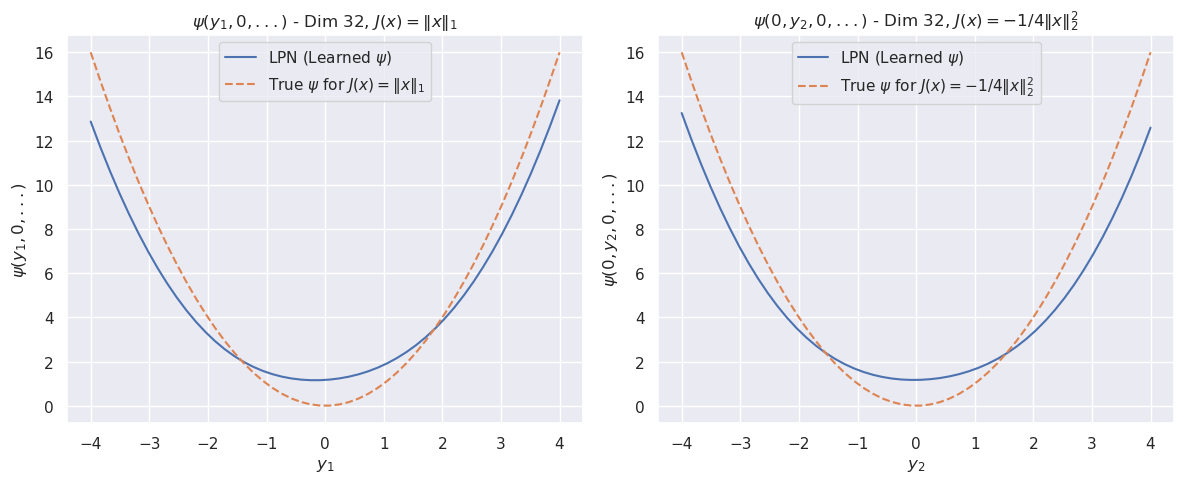

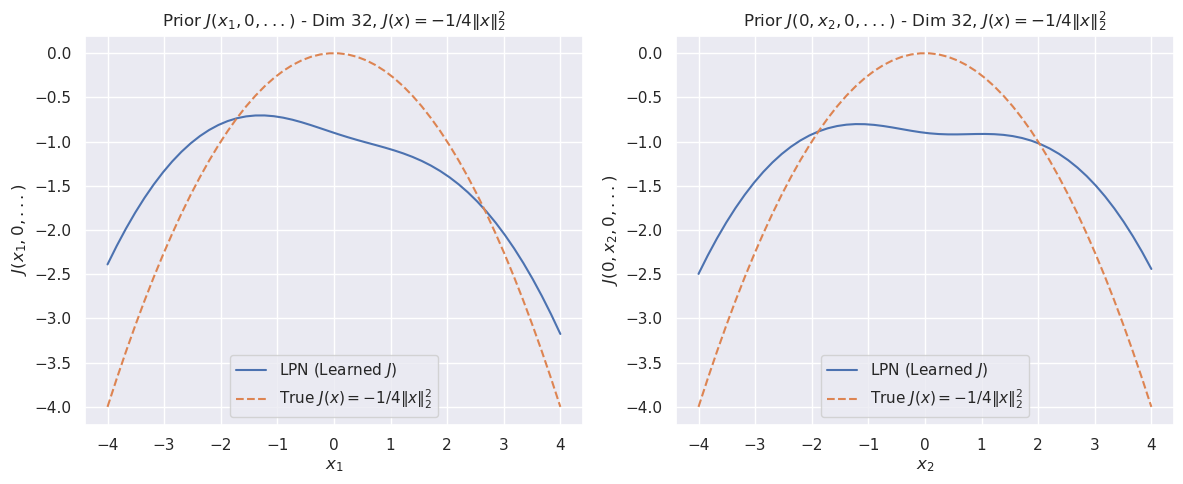

In [8]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
#evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l2(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")

Generated G samples: G_samples_tensor shape torch.Size([40000, 1])


In [10]:
# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 # Use a smaller learning rate for the long phase
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 25765.6640625
iteration 0 loss 10049.8056640625


iteration 500 loss 95.76192474365234


iteration 1000 loss 78.4000015258789


iteration 1500 loss 73.0796890258789


iteration 2000 loss 71.02994537353516


iteration 2500 loss 69.2120361328125


iteration 3000 loss 67.19544982910156


iteration 3500 loss 64.97343444824219


iteration 4000 loss 62.5825309753418


iteration 4500 loss 60.05399703979492


iteration 5000 loss 57.386905670166016


iteration 5500 loss 54.602134704589844


iteration 6000 loss 51.71744155883789


iteration 6500 loss 48.689998626708984


iteration 7000 loss 45.44527816772461


iteration 7500 loss 41.781036376953125


iteration 8000 loss 37.133148193359375


iteration 8500 loss 29.657411575317383


iteration 9000 loss 19.192092895507812


iteration 9500 loss 11.15388298034668


iteration 10000 loss 7.67050838470459


iteration 10500 loss 5.617053031921387


iteration 11000 loss 4.640639305114746


iteration 11500 loss 4.125649929046631


iteration 12000 loss 3.6153576374053955


iteration 12500 loss 3.114332675933838


iteration 13000 loss 2.632669448852539


iteration 13500 loss 2.4758248329162598


iteration 14000 loss 2.3311386108398438


iteration 14500 loss 2.1697616577148438


iteration 15000 loss 1.9916564226150513


iteration 15500 loss 1.7998132705688477


iteration 16000 loss 1.6564476490020752


iteration 16500 loss 1.6078964471817017


iteration 17000 loss 1.5547466278076172


iteration 17500 loss 1.4917349815368652


iteration 18000 loss 1.4178223609924316


iteration 18500 loss 1.3332186937332153


iteration 19000 loss 1.2408692836761475


iteration 19500 loss 1.202680230140686


iteration 20000 loss 1.1756798028945923


iteration 20500 loss 1.1439108848571777


iteration 21000 loss 1.105973482131958


iteration 21500 loss 1.0612589120864868


iteration 22000 loss 1.0097737312316895


iteration 22500 loss 0.9711347222328186


iteration 23000 loss 0.9499608278274536


iteration 23500 loss 0.9267289638519287


iteration 24000 loss 0.8989946842193604


iteration 24500 loss 0.8661274909973145


iteration 25000 loss 0.8931707739830017


iteration 25500 loss 0.8244476318359375


iteration 26000 loss 0.8136184811592102


iteration 26500 loss 0.8013660907745361


iteration 27000 loss 0.7864730358123779


iteration 27500 loss 0.7682521343231201


iteration 28000 loss 0.7462465167045593


iteration 28500 loss 0.7204079031944275


iteration 29000 loss 0.7117092609405518


iteration 29500 loss 0.7031348347663879


iteration 30000 loss 0.6941267251968384


iteration 30500 loss 0.6832411885261536


iteration 31000 loss 0.6698565483093262


iteration 31500 loss 0.6536118984222412


iteration 32000 loss 0.634184718132019


iteration 32500 loss 0.6272258162498474


iteration 33000 loss 0.6198988556861877


iteration 33500 loss 0.6130197048187256


iteration 34000 loss 0.6047901511192322


iteration 34500 loss 0.5946277976036072


iteration 35000 loss 0.5820692777633667


iteration 35500 loss 0.5669448971748352


iteration 36000 loss 0.5611300468444824


iteration 36500 loss 0.5536993741989136


iteration 37000 loss 0.5481330156326294


iteration 37500 loss 0.5417761206626892


iteration 38000 loss 0.5340068936347961


iteration 38500 loss 0.5244004130363464


iteration 39000 loss 0.5128554701805115


iteration 39500 loss 0.9107449054718018


iteration 40000 loss 0.499087929725647


iteration 40500 loss 0.49432048201560974


iteration 41000 loss 0.4895285964012146


iteration 41500 loss 0.4838165044784546


iteration 42000 loss 0.47677069902420044


iteration 42500 loss 0.4680577516555786


iteration 43000 loss 0.4576687514781952


iteration 43500 loss 0.45544931292533875


iteration 44000 loss 0.4505206048488617


iteration 44500 loss 0.44669148325920105


iteration 45000 loss 0.4423494040966034


iteration 45500 loss 0.4370433986186981


iteration 46000 loss 0.4304586946964264


iteration 46500 loss 0.42263495922088623


iteration 47000 loss 0.4204421639442444


iteration 47500 loss 0.41473153233528137


iteration 48000 loss 0.4114115238189697


iteration 48500 loss 0.40778857469558716


iteration 49000 loss 0.4033654034137726


iteration 49500 loss 0.39786335825920105


iteration 50000 loss 0.39113104343414307


iteration 50500 loss 0.3884439468383789


iteration 51000 loss 0.38219189643859863


iteration 51500 loss 0.37839555740356445


iteration 52000 loss 0.3739416003227234


iteration 52500 loss 0.36847764253616333


iteration 53000 loss 0.36184564232826233


iteration 53500 loss 0.36194783449172974


iteration 54000 loss 0.3585222661495209


iteration 54500 loss 0.35584431886672974


iteration 55000 loss 0.35287952423095703


iteration 55500 loss 0.34926480054855347


iteration 56000 loss 0.3447554111480713


iteration 56500 loss 0.3392702639102936


iteration 57000 loss 0.33737996220588684


iteration 57500 loss 0.333420991897583


iteration 58000 loss 0.3304935395717621


iteration 58500 loss 0.3270926773548126


iteration 59000 loss 0.32290032505989075


iteration 59500 loss 0.3181488513946533


iteration 60000 loss 0.31889840960502625


iteration 60500 loss 0.31537947058677673


iteration 61000 loss 0.31312382221221924


iteration 61500 loss 0.31089648604393005


iteration 62000 loss 0.3082982897758484


iteration 62500 loss 0.30510374903678894


iteration 63000 loss 0.30120599269866943


iteration 63500 loss 0.3097563087940216


iteration 64000 loss 0.29742395877838135


iteration 64500 loss 0.2952551543712616


iteration 65000 loss 0.293361097574234


iteration 65500 loss 0.29120737314224243


iteration 66000 loss 0.2885701060295105


iteration 66500 loss 0.2853100597858429


iteration 67000 loss 0.28133276104927063


iteration 67500 loss 0.28041449189186096


iteration 68000 loss 0.2780187427997589


iteration 68500 loss 0.27575600147247314


iteration 69000 loss 0.2730368673801422


iteration 69500 loss 0.26970168948173523


iteration 70000 loss 0.27127671241760254


iteration 70500 loss 0.26786670088768005


iteration 71000 loss 0.2660385072231293


iteration 71500 loss 0.2643791735172272


iteration 72000 loss 0.2624989151954651


iteration 72500 loss 0.2602006196975708


iteration 73000 loss 0.2573877274990082


iteration 73500 loss 0.2599901854991913


iteration 74000 loss 0.25383713841438293


iteration 74500 loss 0.2520228922367096


iteration 75000 loss 0.250160276889801


iteration 75500 loss 0.24790087342262268


iteration 76000 loss 0.24511834979057312


iteration 76500 loss 0.24521556496620178


iteration 77000 loss 0.24286402761936188


iteration 77500 loss 0.24141532182693481


iteration 78000 loss 0.23988275229930878


iteration 78500 loss 0.23803016543388367


iteration 79000 loss 0.23574060201644897


iteration 79500 loss 0.2424061894416809


iteration 80000 loss 0.2333141565322876


iteration 80500 loss 0.23183095455169678


iteration 81000 loss 0.23049965500831604


iteration 81500 loss 0.22894501686096191


iteration 82000 loss 0.22702264785766602


iteration 82500 loss 0.22466832399368286


iteration 83000 loss 0.22572775185108185


iteration 83500 loss 0.2238331437110901


iteration 84000 loss 0.2226487249135971


iteration 84500 loss 0.2214973270893097


iteration 85000 loss 0.22015522420406342


iteration 85500 loss 0.21850766241550446


iteration 86000 loss 0.2164696902036667


iteration 86500 loss 0.218507319688797


iteration 87000 loss 0.215737447142601


iteration 87500 loss 0.21440741419792175


iteration 88000 loss 0.2133110761642456


iteration 88500 loss 0.21213369071483612


iteration 89000 loss 0.21071842312812805


iteration 89500 loss 0.2089691162109375


iteration 90000 loss 0.21457220613956451


iteration 90500 loss 0.20771507918834686


iteration 91000 loss 0.20629672706127167


iteration 91500 loss 0.20521362125873566


iteration 92000 loss 0.20404937863349915


iteration 92500 loss 0.2026471197605133


iteration 93000 loss 0.20092956721782684


iteration 93500 loss 0.20149904489517212


iteration 94000 loss 0.1992015540599823


iteration 94500 loss 0.1980295181274414


iteration 95000 loss 0.19681724905967712


iteration 95500 loss 0.1953490674495697


iteration 96000 loss 0.20231440663337708


iteration 96500 loss 0.19501228630542755


iteration 97000 loss 0.19354289770126343


iteration 97500 loss 0.1925700455904007


iteration 98000 loss 0.19164252281188965


iteration 98500 loss 0.1905800700187683


iteration 99000 loss 0.18928587436676025


iteration 99500 loss 0.1877109259366989


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.18859833478927612


iteration 100500 loss 0.18835923075675964


iteration 101000 loss 0.18810178339481354


iteration 101500 loss 0.18782640993595123


iteration 102000 loss 0.18753693997859955


iteration 102500 loss 0.18723560869693756


iteration 103000 loss 0.18692104518413544


iteration 103500 loss 0.18658405542373657


iteration 104000 loss 0.1862114667892456


iteration 104500 loss 0.18578381836414337


iteration 105000 loss 0.18527443706989288


iteration 105500 loss 0.1846499890089035


iteration 106000 loss 0.18387416005134583


iteration 106500 loss 0.1829044073820114


iteration 107000 loss 0.18169480562210083


iteration 107500 loss 0.18020778894424438


iteration 108000 loss 0.17943349480628967


iteration 108500 loss 0.17909106612205505


iteration 109000 loss 0.17866498231887817


iteration 109500 loss 0.17812424898147583


iteration 110000 loss 0.1774381399154663


iteration 110500 loss 0.17656868696212769


iteration 111000 loss 0.17547321319580078


iteration 111500 loss 0.17411845922470093


iteration 112000 loss 0.17314094305038452


iteration 112500 loss 0.172755628824234


iteration 113000 loss 0.17227201163768768


iteration 113500 loss 0.17165669798851013


iteration 114000 loss 0.1708746701478958


iteration 114500 loss 0.16988593339920044


iteration 115000 loss 0.16865214705467224


iteration 115500 loss 0.1675560027360916


iteration 116000 loss 0.1671932339668274


iteration 116500 loss 0.16676299273967743


iteration 117000 loss 0.1662178486585617


iteration 117500 loss 0.1655270755290985


iteration 118000 loss 0.16465553641319275


iteration 118500 loss 0.16356682777404785


iteration 119000 loss 0.17238888144493103


iteration 119500 loss 0.16193532943725586


iteration 120000 loss 0.1614973396062851


iteration 120500 loss 0.1609405279159546


iteration 121000 loss 0.16023315489292145


iteration 121500 loss 0.15933732688426971


iteration 122000 loss 0.15822157263755798


iteration 122500 loss 0.15737053751945496


iteration 123000 loss 0.15709850192070007


iteration 123500 loss 0.15679043531417847


iteration 124000 loss 0.15639902651309967


iteration 124500 loss 0.15590016543865204


iteration 125000 loss 0.1552654206752777


iteration 125500 loss 0.15446113049983978


iteration 126000 loss 0.1534641981124878


iteration 126500 loss 0.15248683094978333


iteration 127000 loss 0.15215016901493073


iteration 127500 loss 0.1518530696630478


iteration 128000 loss 0.15147636830806732


iteration 128500 loss 0.1509968638420105


iteration 129000 loss 0.15038760006427765


iteration 129500 loss 0.14961662888526917


iteration 130000 loss 0.14865538477897644


iteration 130500 loss 0.14771926403045654


iteration 131000 loss 0.14735709130764008


iteration 131500 loss 0.14692844450473785


iteration 132000 loss 0.14638346433639526


iteration 132500 loss 0.14569157361984253


iteration 133000 loss 0.14481902122497559


iteration 133500 loss 0.1699678748846054


iteration 134000 loss 0.1435951441526413


iteration 134500 loss 0.14334364235401154


iteration 135000 loss 0.1430254429578781


iteration 135500 loss 0.14262020587921143


iteration 136000 loss 0.14210449159145355


iteration 136500 loss 0.14145046472549438


iteration 137000 loss 0.14063118398189545


iteration 137500 loss 0.13962335884571075


iteration 138000 loss 0.1394396871328354


iteration 138500 loss 0.13922302424907684


iteration 139000 loss 0.13895316421985626


iteration 139500 loss 0.13861005008220673


iteration 140000 loss 0.13817404210567474


iteration 140500 loss 0.13762091100215912


iteration 141000 loss 0.136923149228096


iteration 141500 loss 0.13605688512325287


iteration 142000 loss 0.13552828133106232


iteration 142500 loss 0.13532932102680206


iteration 143000 loss 0.13510246574878693


iteration 143500 loss 0.13481469452381134


iteration 144000 loss 0.1344480961561203


iteration 144500 loss 0.13398149609565735


iteration 145000 loss 0.1333899199962616


iteration 145500 loss 0.13264676928520203


iteration 146000 loss 0.13477785885334015


iteration 146500 loss 0.13165372610092163


iteration 147000 loss 0.13145922124385834


iteration 147500 loss 0.1312141865491867


iteration 148000 loss 0.13090206682682037


iteration 148500 loss 0.13050462305545807


iteration 149000 loss 0.1299993097782135


iteration 149500 loss 0.1293615698814392


iteration 150000 loss 0.12856827676296234


iteration 150500 loss 0.12822629511356354


iteration 151000 loss 0.128051295876503


iteration 151500 loss 0.12783463299274445


iteration 152000 loss 0.12755870819091797


iteration 152500 loss 0.12720666825771332


iteration 153000 loss 0.12675869464874268


iteration 153500 loss 0.126190647482872


iteration 154000 loss 0.12547944486141205


iteration 154500 loss 0.12496256828308105


iteration 155000 loss 0.12474106252193451


iteration 155500 loss 0.12446783483028412


iteration 156000 loss 0.1241198480129242


iteration 156500 loss 0.12367703765630722


iteration 157000 loss 0.12311545014381409


iteration 157500 loss 0.12241258472204208


iteration 158000 loss 0.122041717171669


iteration 158500 loss 0.12180629372596741


iteration 159000 loss 0.12150917947292328


iteration 159500 loss 0.1211308166384697


iteration 160000 loss 0.12065046280622482


iteration 160500 loss 0.12004540860652924


iteration 161000 loss 0.11949542164802551


iteration 161500 loss 0.11929675191640854


iteration 162000 loss 0.11912313848733902


iteration 162500 loss 0.11890289187431335


iteration 163000 loss 0.11862209439277649


iteration 163500 loss 0.11826426535844803


iteration 164000 loss 0.11780872195959091


iteration 164500 loss 0.11723873019218445


iteration 165000 loss 0.11676109582185745


iteration 165500 loss 0.11658240854740143


iteration 166000 loss 0.1164272204041481


iteration 166500 loss 0.11623107641935349


iteration 167000 loss 0.11598068475723267


iteration 167500 loss 0.11566130071878433


iteration 168000 loss 0.11525451391935349


iteration 168500 loss 0.11474157124757767


iteration 169000 loss 0.11410197615623474


iteration 169500 loss 0.11395871639251709


iteration 170000 loss 0.11382458359003067


iteration 170500 loss 0.11365772783756256


iteration 171000 loss 0.11344518512487411


iteration 171500 loss 0.11317417770624161


iteration 172000 loss 0.11282912641763687


iteration 172500 loss 0.11239100992679596


iteration 173000 loss 0.11184146255254745


iteration 173500 loss 0.11148878186941147


iteration 174000 loss 0.11135390400886536


iteration 174500 loss 0.1112108826637268


iteration 175000 loss 0.11102936416864395


iteration 175500 loss 0.11079785227775574


iteration 176000 loss 0.11050236225128174


iteration 176500 loss 0.1101258248090744


iteration 177000 loss 0.10965224355459213


iteration 177500 loss 0.12585511803627014


iteration 178000 loss 0.10899914056062698


iteration 178500 loss 0.10887464135885239


iteration 179000 loss 0.10872067511081696


iteration 179500 loss 0.10852435976266861


iteration 180000 loss 0.10827398300170898


iteration 180500 loss 0.1079547330737114


iteration 181000 loss 0.10755014419555664


iteration 181500 loss 0.10704445838928223


iteration 182000 loss 0.10671054571866989


iteration 182500 loss 0.1065848097205162


iteration 183000 loss 0.10643428564071655


iteration 183500 loss 0.10624272376298904


iteration 184000 loss 0.10599825531244278


iteration 184500 loss 0.10568664222955704


iteration 185000 loss 0.10529103875160217


iteration 185500 loss 0.10479499399662018


iteration 186000 loss 0.10451475530862808


iteration 186500 loss 0.10435400158166885


iteration 187000 loss 0.1041521206498146


iteration 187500 loss 0.10389461368322372


iteration 188000 loss 0.10356616228818893


iteration 188500 loss 0.10314958542585373


iteration 189000 loss 0.10853260010480881


iteration 189500 loss 0.10259111225605011


iteration 190000 loss 0.10248258709907532


iteration 190500 loss 0.10234978795051575


iteration 191000 loss 0.10218075662851334


iteration 191500 loss 0.10196503251791


iteration 192000 loss 0.10168981552124023


iteration 192500 loss 0.1013399139046669


iteration 193000 loss 0.10089928656816483


iteration 193500 loss 0.10057028383016586


iteration 194000 loss 0.10041040182113647


iteration 194500 loss 0.10021325200796127


iteration 195000 loss 0.09996166080236435


iteration 195500 loss 0.09964046627283096


iteration 196000 loss 0.09923670440912247


iteration 196500 loss 0.09890177100896835


iteration 197000 loss 0.09876734018325806


iteration 197500 loss 0.09865511208772659


iteration 198000 loss 0.09851318597793579


iteration 198500 loss 0.09833187609910965


iteration 199000 loss 0.0981002077460289


iteration 199500 loss 0.09780479222536087


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.09742990136146545


iteration 200500 loss 0.09738168120384216


iteration 201000 loss 0.09732071310281754


iteration 201500 loss 0.0972428098320961


iteration 202000 loss 0.09714348614215851


iteration 202500 loss 0.09701690822839737


iteration 203000 loss 0.0968565046787262


iteration 203500 loss 0.09665435552597046


iteration 204000 loss 0.09640131890773773


iteration 204500 loss 0.09608739614486694


iteration 205000 loss 0.09570317715406418


iteration 205500 loss 0.0954051986336708


iteration 206000 loss 0.09510631114244461


iteration 206500 loss 0.09473970532417297


iteration 207000 loss 0.09443793445825577


iteration 207500 loss 0.09416159242391586


iteration 208000 loss 0.09382133185863495


iteration 208500 loss 0.09349431097507477


iteration 209000 loss 0.09326468408107758


iteration 209500 loss 0.09297958761453629


iteration 210000 loss 0.09262947738170624


iteration 210500 loss 0.09234390407800674


iteration 211000 loss 0.09208782017230988


iteration 211500 loss 0.09177187830209732


iteration 212000 loss 0.09143335372209549


iteration 212500 loss 0.09121687710285187


iteration 213000 loss 0.09094806015491486


iteration 213500 loss 0.09061762690544128


iteration 214000 loss 0.09035367518663406


iteration 214500 loss 0.09015927463769913


iteration 215000 loss 0.0899171531200409


iteration 215500 loss 0.08961845189332962


iteration 216000 loss 0.08929109573364258


iteration 216500 loss 0.08912213891744614


iteration 217000 loss 0.08891092240810394


iteration 217500 loss 0.08864884823560715


iteration 218000 loss 0.08832741528749466


iteration 218500 loss 0.08807799220085144


iteration 219000 loss 0.08785150200128555


iteration 219500 loss 0.08757120370864868


iteration 220000 loss 0.0872487872838974


iteration 220500 loss 0.08706264197826385


iteration 221000 loss 0.08683101832866669


iteration 221500 loss 0.08654508739709854


iteration 222000 loss 0.08625919371843338


iteration 222500 loss 0.08607415854930878


iteration 223000 loss 0.08584386110305786


iteration 223500 loss 0.08555980026721954


iteration 224000 loss 0.08528990298509598


iteration 224500 loss 0.08511549979448318


iteration 225000 loss 0.08489808440208435


iteration 225500 loss 0.08462903648614883


iteration 226000 loss 0.08433603495359421


iteration 226500 loss 0.08415340632200241


iteration 227000 loss 0.08392607420682907


iteration 227500 loss 0.08364594727754593


iteration 228000 loss 0.08339706808328629


iteration 228500 loss 0.08319747447967529


iteration 229000 loss 0.08294989168643951


iteration 229500 loss 0.08264728635549545


iteration 230000 loss 0.08250477910041809


iteration 230500 loss 0.08234511315822601


iteration 231000 loss 0.08214571326971054


iteration 231500 loss 0.08189864456653595


iteration 232000 loss 0.08160293102264404


iteration 232500 loss 0.081429623067379


iteration 233000 loss 0.08121415972709656


iteration 233500 loss 0.080948606133461


iteration 234000 loss 0.08071549236774445


iteration 234500 loss 0.08053067326545715


iteration 235000 loss 0.08030115067958832


iteration 235500 loss 0.0800197497010231


iteration 236000 loss 0.07983763515949249


iteration 236500 loss 0.07963860034942627


iteration 237000 loss 0.0793921947479248


iteration 237500 loss 0.07914336025714874


iteration 238000 loss 0.07896751165390015


iteration 238500 loss 0.07874879240989685


iteration 239000 loss 0.07848039269447327


iteration 239500 loss 0.07831909507513046


iteration 240000 loss 0.07816425710916519


iteration 240500 loss 0.07797113060951233


iteration 241000 loss 0.07773274183273315


iteration 241500 loss 0.07749340683221817


iteration 242000 loss 0.07732830196619034


iteration 242500 loss 0.07712294906377792


iteration 243000 loss 0.07687007635831833


iteration 243500 loss 0.07667917013168335


iteration 244000 loss 0.07650398463010788


iteration 244500 loss 0.07628629356622696


iteration 245000 loss 0.07602693885564804


iteration 245500 loss 0.0758715271949768


iteration 246000 loss 0.07568096369504929


iteration 246500 loss 0.0754457637667656


iteration 247000 loss 0.07523752748966217


iteration 247500 loss 0.07507312297821045


iteration 248000 loss 0.0748688280582428


iteration 248500 loss 0.07461798936128616


iteration 249000 loss 0.07448585331439972


iteration 249500 loss 0.07434432208538055


iteration 250000 loss 0.07416769862174988


iteration 250500 loss 0.07394932955503464


iteration 251000 loss 0.07372720539569855


iteration 251500 loss 0.07357930392026901


iteration 252000 loss 0.07339507341384888


iteration 252500 loss 0.07316780835390091


iteration 253000 loss 0.07299516350030899


iteration 253500 loss 0.0728687271475792


iteration 254000 loss 0.0727103129029274


iteration 254500 loss 0.07251351326704025


iteration 255000 loss 0.07227226346731186


iteration 255500 loss 0.07212787121534348


iteration 256000 loss 0.07195856422185898


iteration 256500 loss 0.07174886018037796


iteration 257000 loss 0.07153713703155518


iteration 257500 loss 0.07139429450035095


iteration 258000 loss 0.07121630758047104


iteration 258500 loss 0.0709964707493782


iteration 259000 loss 0.07084660232067108


iteration 259500 loss 0.07074432820081711


iteration 260000 loss 0.0706159770488739


iteration 260500 loss 0.07045545428991318


iteration 261000 loss 0.07025668770074844


iteration 261500 loss 0.07005402445793152


iteration 262000 loss 0.06997165083885193


iteration 262500 loss 0.06986770778894424


iteration 263000 loss 0.06973719596862793


iteration 263500 loss 0.06957397609949112


iteration 264000 loss 0.0693720281124115


iteration 264500 loss 0.06918038427829742


iteration 265000 loss 0.0690491572022438


iteration 265500 loss 0.06888502091169357


iteration 266000 loss 0.06868177652359009


iteration 266500 loss 0.06852774322032928


iteration 267000 loss 0.06844332069158554


iteration 267500 loss 0.068337082862854


iteration 268000 loss 0.06820350885391235


iteration 268500 loss 0.06803681701421738


iteration 269000 loss 0.06783127039670944


iteration 269500 loss 0.0676741823554039


iteration 270000 loss 0.06753682345151901


iteration 270500 loss 0.06736548990011215


iteration 271000 loss 0.06715420633554459


iteration 271500 loss 0.0670611709356308


iteration 272000 loss 0.06697751581668854


iteration 272500 loss 0.06687205284833908


iteration 273000 loss 0.06673955917358398


iteration 273500 loss 0.06657423079013824


iteration 274000 loss 0.06637037545442581


iteration 274500 loss 0.0662662610411644


iteration 275000 loss 0.06618088483810425


iteration 275500 loss 0.06607332080602646


iteration 276000 loss 0.06593811511993408


iteration 276500 loss 0.06576967239379883


iteration 277000 loss 0.0655626729130745


iteration 277500 loss 0.06544571369886398


iteration 278000 loss 0.06530416011810303


iteration 278500 loss 0.06512798368930817


iteration 279000 loss 0.06494688242673874


iteration 279500 loss 0.06483525782823563


iteration 280000 loss 0.0646953135728836


iteration 280500 loss 0.0645211786031723


iteration 281000 loss 0.0643422082066536


iteration 281500 loss 0.06422857195138931


iteration 282000 loss 0.06408604234457016


iteration 282500 loss 0.06390904635190964


iteration 283000 loss 0.06376471370458603


iteration 283500 loss 0.06368840485811234


iteration 284000 loss 0.06359221041202545


iteration 284500 loss 0.0634712278842926


iteration 285000 loss 0.06331992894411087


iteration 285500 loss 0.06313309073448181


iteration 286000 loss 0.06303079426288605


iteration 286500 loss 0.06294059753417969


iteration 287000 loss 0.06282681971788406


iteration 287500 loss 0.06268434971570969


iteration 288000 loss 0.06250756233930588


iteration 288500 loss 0.06239313632249832


iteration 289000 loss 0.06232006102800369


iteration 289500 loss 0.062227763235569


iteration 290000 loss 0.06211143732070923


iteration 290500 loss 0.06196561083197594


iteration 291000 loss 0.06178545206785202


iteration 291500 loss 0.06166783347725868


iteration 292000 loss 0.061548974364995956


iteration 292500 loss 0.06140020117163658


iteration 293000 loss 0.061216406524181366


iteration 293500 loss 0.06115618720650673


iteration 294000 loss 0.06108662113547325


iteration 294500 loss 0.06099851429462433


iteration 295000 loss 0.060887411236763


iteration 295500 loss 0.06074819341301918


iteration 296000 loss 0.06057586520910263


iteration 296500 loss 0.060488346964120865


iteration 297000 loss 0.060424596071243286


iteration 297500 loss 0.06034397333860397


iteration 298000 loss 0.06024208664894104


iteration 298500 loss 0.06011393293738365


iteration 299000 loss 0.05995473638176918


iteration 299500 loss 0.059831466525793076


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.05977429077029228


iteration 300500 loss 0.05976780131459236


iteration 301000 loss 0.059759244322776794


iteration 301500 loss 0.05974802002310753


iteration 302000 loss 0.059733446687459946


iteration 302500 loss 0.059714946895837784


iteration 303000 loss 0.05969192460179329


iteration 303500 loss 0.05966441333293915


iteration 304000 loss 0.059631627053022385


iteration 304500 loss 0.059593286365270615


iteration 305000 loss 0.05954867973923683


iteration 305500 loss 0.05949812009930611


iteration 306000 loss 0.05944133922457695


iteration 306500 loss 0.0593789778649807


iteration 307000 loss 0.05931179225444794


iteration 307500 loss 0.059240929782390594


iteration 308000 loss 0.059168651700019836


iteration 308500 loss 0.059097204357385635


iteration 309000 loss 0.05902652442455292


iteration 309500 loss 0.05895652249455452


iteration 310000 loss 0.0588873028755188


iteration 310500 loss 0.058818601071834564


iteration 311000 loss 0.058750346302986145


iteration 311500 loss 0.05868252366781235


iteration 312000 loss 0.0586150698363781


iteration 312500 loss 0.05854808911681175


iteration 313000 loss 0.058481406420469284


iteration 313500 loss 0.05841517075896263


iteration 314000 loss 0.05834927037358284


iteration 314500 loss 0.058283690363168716


iteration 315000 loss 0.058218419551849365


iteration 315500 loss 0.058153409510850906


iteration 316000 loss 0.05808877944946289


iteration 316500 loss 0.058024484664201736


iteration 317000 loss 0.05796040967106819


iteration 317500 loss 0.05789664015173912


iteration 318000 loss 0.05783332511782646


iteration 318500 loss 0.05777006596326828


iteration 319000 loss 0.057707201689481735


iteration 319500 loss 0.05764450505375862


iteration 320000 loss 0.057582054287195206


iteration 320500 loss 0.057519737631082535


iteration 321000 loss 0.057457756251096725


iteration 321500 loss 0.05739600583910942


iteration 322000 loss 0.057334378361701965


iteration 322500 loss 0.057272959500551224


iteration 323000 loss 0.05721166729927063


iteration 323500 loss 0.057150695472955704


iteration 324000 loss 0.05708983540534973


iteration 324500 loss 0.05702925845980644


iteration 325000 loss 0.056968845427036285


iteration 325500 loss 0.05690855532884598


iteration 326000 loss 0.05684853345155716


iteration 326500 loss 0.05678877234458923


iteration 327000 loss 0.056729063391685486


iteration 327500 loss 0.05666954815387726


iteration 328000 loss 0.056610241532325745


iteration 328500 loss 0.056551072746515274


iteration 329000 loss 0.05649206414818764


iteration 329500 loss 0.056433361023664474


iteration 330000 loss 0.056374695152044296


iteration 330500 loss 0.05631628260016441


iteration 331000 loss 0.05625809356570244


iteration 331500 loss 0.05619996041059494


iteration 332000 loss 0.056141942739486694


iteration 332500 loss 0.056084178388118744


iteration 333000 loss 0.056026678532361984


iteration 333500 loss 0.05596907064318657


iteration 334000 loss 0.05591173097491264


iteration 334500 loss 0.05585445463657379


iteration 335000 loss 0.05579739809036255


iteration 335500 loss 0.05574052408337593


iteration 336000 loss 0.05568381026387215


iteration 336500 loss 0.05562710389494896


iteration 337000 loss 0.05557059869170189


iteration 337500 loss 0.055514249950647354


iteration 338000 loss 0.05545816570520401


iteration 338500 loss 0.05540215224027634


iteration 339000 loss 0.05534626170992851


iteration 339500 loss 0.05529046431183815


iteration 340000 loss 0.0552348755300045


iteration 340500 loss 0.05517934262752533


iteration 341000 loss 0.055123791098594666


iteration 341500 loss 0.05506842955946922


iteration 342000 loss 0.05501319468021393


iteration 342500 loss 0.05495815351605415


iteration 343000 loss 0.054903093725442886


iteration 343500 loss 0.05484822764992714


iteration 344000 loss 0.05479343608021736


iteration 344500 loss 0.05473883077502251


iteration 345000 loss 0.05468426272273064


iteration 345500 loss 0.054629772901535034


iteration 346000 loss 0.05457549914717674


iteration 346500 loss 0.05452122539281845


iteration 347000 loss 0.05446711182594299


iteration 347500 loss 0.054413072764873505


iteration 348000 loss 0.05435912311077118


iteration 348500 loss 0.05430541932582855


iteration 349000 loss 0.054251719266176224


iteration 349500 loss 0.054198168218135834


iteration 350000 loss 0.05414470657706261


iteration 350500 loss 0.054091356694698334


iteration 351000 loss 0.05403813347220421


iteration 351500 loss 0.05398492142558098


iteration 352000 loss 0.05393178015947342


iteration 352500 loss 0.053878817707300186


iteration 353000 loss 0.05382588505744934


iteration 353500 loss 0.053773120045661926


iteration 354000 loss 0.05372045934200287


iteration 354500 loss 0.0536678209900856


iteration 355000 loss 0.05361534282565117


iteration 355500 loss 0.053562961518764496


iteration 356000 loss 0.05351075157523155


iteration 356500 loss 0.05345853790640831


iteration 357000 loss 0.053406454622745514


iteration 357500 loss 0.053354453295469284


iteration 358000 loss 0.053302597254514694


iteration 358500 loss 0.053250815719366074


iteration 359000 loss 0.053199008107185364


iteration 359500 loss 0.053147461265325546


iteration 360000 loss 0.053095873445272446


iteration 360500 loss 0.053044479340314865


iteration 361000 loss 0.05299315229058266


iteration 361500 loss 0.05294185131788254


iteration 362000 loss 0.052890557795763016


iteration 362500 loss 0.052839431911706924


iteration 363000 loss 0.052788395434617996


iteration 363500 loss 0.05273735895752907


iteration 364000 loss 0.052686456590890884


iteration 364500 loss 0.052635665982961655


iteration 365000 loss 0.0525849349796772


iteration 365500 loss 0.05253424495458603


iteration 366000 loss 0.052483703941106796


iteration 366500 loss 0.05243318900465965


iteration 367000 loss 0.05238274857401848


iteration 367500 loss 0.05233243107795715


iteration 368000 loss 0.05228215083479881


iteration 368500 loss 0.05223195627331734


iteration 369000 loss 0.052181921899318695


iteration 369500 loss 0.052131857722997665


iteration 370000 loss 0.052081894129514694


iteration 370500 loss 0.05203194543719292


iteration 371000 loss 0.05198223143815994


iteration 371500 loss 0.05193246901035309


iteration 372000 loss 0.051882803440093994


iteration 372500 loss 0.05183328688144684


iteration 373000 loss 0.051783762872219086


iteration 373500 loss 0.0517343170940876


iteration 374000 loss 0.051685068756341934


iteration 374500 loss 0.051635850220918655


iteration 375000 loss 0.051586609333753586


iteration 375500 loss 0.05153751000761986


iteration 376000 loss 0.05148846283555031


iteration 376500 loss 0.05143940448760986


iteration 377000 loss 0.05139048770070076


iteration 377500 loss 0.051341697573661804


iteration 378000 loss 0.05129294842481613


iteration 378500 loss 0.051244188100099564


iteration 379000 loss 0.05119558423757553


iteration 379500 loss 0.05114703252911568


iteration 380000 loss 0.051098547875881195


iteration 380500 loss 0.051050085574388504


iteration 381000 loss 0.051001712679862976


iteration 381500 loss 0.050953373312950134


iteration 382000 loss 0.050905074924230576


iteration 382500 loss 0.05085688456892967


iteration 383000 loss 0.05080880969762802


iteration 383500 loss 0.050760794430971146


iteration 384000 loss 0.05071280896663666


iteration 384500 loss 0.0506649911403656


iteration 385000 loss 0.05061715468764305


iteration 385500 loss 0.05056935176253319


iteration 386000 loss 0.050521623343229294


iteration 386500 loss 0.05047406628727913


iteration 387000 loss 0.0504264272749424


iteration 387500 loss 0.05037900432944298


iteration 388000 loss 0.05033162981271744


iteration 388500 loss 0.05028427019715309


iteration 389000 loss 0.050237033516168594


iteration 389500 loss 0.050189804285764694


iteration 390000 loss 0.05014272779226303


iteration 390500 loss 0.050095610320568085


iteration 391000 loss 0.050048623234033585


iteration 391500 loss 0.050001781433820724


iteration 392000 loss 0.04995498061180115


iteration 392500 loss 0.04990807920694351


iteration 393000 loss 0.0498613566160202


iteration 393500 loss 0.049814675003290176


iteration 394000 loss 0.04976815730333328


iteration 394500 loss 0.04972163960337639


iteration 395000 loss 0.049675144255161285


iteration 395500 loss 0.049628812819719315


iteration 396000 loss 0.04958250746130943


iteration 396500 loss 0.049536217004060745


iteration 397000 loss 0.04949010908603668


iteration 397500 loss 0.04944403097033501


iteration 398000 loss 0.049398038536310196


iteration 398500 loss 0.049352072179317474


iteration 399000 loss 0.04930611327290535


iteration 399500 loss 0.04926029220223427


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.04921458289027214


iteration 400500 loss 0.04921038821339607


iteration 401000 loss 0.04920601844787598


iteration 401500 loss 0.04920141398906708


iteration 402000 loss 0.049196649342775345


iteration 402500 loss 0.04919184371829033


iteration 403000 loss 0.049186792224645615


iteration 403500 loss 0.04918183013796806


iteration 404000 loss 0.049176737666130066


iteration 404500 loss 0.0491715669631958


iteration 405000 loss 0.0491664856672287


iteration 405500 loss 0.049161411821842194


iteration 406000 loss 0.04915634170174599


iteration 406500 loss 0.0491512306034565


iteration 407000 loss 0.0491461306810379


iteration 407500 loss 0.04914110526442528


iteration 408000 loss 0.04913609102368355


iteration 408500 loss 0.04913105443120003


iteration 409000 loss 0.04912611097097397


iteration 409500 loss 0.04912109673023224


iteration 410000 loss 0.049116142094135284


iteration 410500 loss 0.04911113902926445


iteration 411000 loss 0.04910622537136078


iteration 411500 loss 0.04910128563642502


iteration 412000 loss 0.04909643158316612


iteration 412500 loss 0.049091462045907974


iteration 413000 loss 0.04908652976155281


iteration 413500 loss 0.04908163473010063


iteration 414000 loss 0.04907672107219696


iteration 414500 loss 0.04907185211777687


iteration 415000 loss 0.049066998064517975


iteration 415500 loss 0.04906212165951729


iteration 416000 loss 0.0490572564303875


iteration 416500 loss 0.04905238002538681


iteration 417000 loss 0.0490475557744503


iteration 417500 loss 0.04904273524880409


iteration 418000 loss 0.04903791472315788


iteration 418500 loss 0.049033068120479584


iteration 419000 loss 0.04902822896838188


iteration 419500 loss 0.04902341961860657


iteration 420000 loss 0.04901861026883125


iteration 420500 loss 0.04901387169957161


iteration 421000 loss 0.049008987843990326


iteration 421500 loss 0.049004197120666504


iteration 422000 loss 0.04899945855140686


iteration 422500 loss 0.04899464175105095


iteration 423000 loss 0.04898983612656593


iteration 423500 loss 0.048985112458467484


iteration 424000 loss 0.04898032173514366


iteration 424500 loss 0.04897556081414223


iteration 425000 loss 0.04897080734372139


iteration 425500 loss 0.048966068774461746


iteration 426000 loss 0.0489613302052021


iteration 426500 loss 0.04895658418536186


iteration 427000 loss 0.04895178601145744


iteration 427500 loss 0.048947133123874664


iteration 428000 loss 0.048942383378744125


iteration 428500 loss 0.04893762618303299


iteration 429000 loss 0.04893294721841812


iteration 429500 loss 0.04892820492386818


iteration 430000 loss 0.04892345517873764


iteration 430500 loss 0.04891879856586456


iteration 431000 loss 0.04891404137015343


iteration 431500 loss 0.04890938103199005


iteration 432000 loss 0.04890467971563339


iteration 432500 loss 0.048900019377470016


iteration 433000 loss 0.048895273357629776


iteration 433500 loss 0.0488906167447567


iteration 434000 loss 0.04888593778014183


iteration 434500 loss 0.04888126626610756


iteration 435000 loss 0.048876602202653885


iteration 435500 loss 0.04887184500694275


iteration 436000 loss 0.04886722192168236


iteration 436500 loss 0.04886255040764809


iteration 437000 loss 0.048857901245355606


iteration 437500 loss 0.04885324090719223


iteration 438000 loss 0.04884859174489975


iteration 438500 loss 0.04884392395615578


iteration 439000 loss 0.04883929342031479


iteration 439500 loss 0.048834625631570816


iteration 440000 loss 0.048830028623342514


iteration 440500 loss 0.048825353384017944


iteration 441000 loss 0.04882076755166054


iteration 441500 loss 0.04881610721349716


iteration 442000 loss 0.048811476677656174


iteration 442500 loss 0.048806846141815186


iteration 443000 loss 0.04880224168300629


iteration 443500 loss 0.0487976111471653


iteration 444000 loss 0.0487929992377758


iteration 444500 loss 0.0487884096801281


iteration 445000 loss 0.04878374934196472


iteration 445500 loss 0.048779211938381195


iteration 446000 loss 0.04877456650137901


iteration 446500 loss 0.048769980669021606


iteration 447000 loss 0.04876535385847092


iteration 447500 loss 0.048760753124952316


iteration 448000 loss 0.04875616729259491


iteration 448500 loss 0.048751577734947205


iteration 449000 loss 0.04874690622091293


iteration 449500 loss 0.04874236509203911


iteration 450000 loss 0.04873782768845558


iteration 450500 loss 0.04873327538371086


iteration 451000 loss 0.048728689551353455


iteration 451500 loss 0.048724062740802765


iteration 452000 loss 0.04871951788663864


iteration 452500 loss 0.04871499165892601


iteration 453000 loss 0.04871036484837532


iteration 453500 loss 0.04870583117008209


iteration 454000 loss 0.04870125651359558


iteration 454500 loss 0.04869668930768967


iteration 455000 loss 0.04869209602475166


iteration 455500 loss 0.04868755489587784


iteration 456000 loss 0.048683006316423416


iteration 456500 loss 0.048678457736968994


iteration 457000 loss 0.048673953860998154


iteration 457500 loss 0.04866942763328552


iteration 458000 loss 0.04866478964686394


iteration 458500 loss 0.04866032674908638


iteration 459000 loss 0.04865574836730957


iteration 459500 loss 0.048651233315467834


iteration 460000 loss 0.04864664748311043


iteration 460500 loss 0.048642124980688095


iteration 461000 loss 0.04863760620355606


iteration 461500 loss 0.04863310232758522


iteration 462000 loss 0.0486285574734211


iteration 462500 loss 0.04862407594919205


iteration 463000 loss 0.04861956089735031


iteration 463500 loss 0.04861502721905708


iteration 464000 loss 0.04861055314540863


iteration 464500 loss 0.04860599339008331


iteration 465000 loss 0.048601482063531876


iteration 465500 loss 0.04859694093465805


iteration 466000 loss 0.04859251156449318


iteration 466500 loss 0.048587992787361145


iteration 467000 loss 0.0485834963619709


iteration 467500 loss 0.04857897385954857


iteration 468000 loss 0.04857448488473892


iteration 468500 loss 0.04856996610760689


iteration 469000 loss 0.04856552183628082


iteration 469500 loss 0.04856104776263237


iteration 470000 loss 0.04855652526021004


iteration 470500 loss 0.04855208098888397


iteration 471000 loss 0.04854758083820343


iteration 471500 loss 0.04854312539100647


iteration 472000 loss 0.04853861406445503


iteration 472500 loss 0.04853413626551628


iteration 473000 loss 0.04852966591715813


iteration 473500 loss 0.048525188118219376


iteration 474000 loss 0.0485207624733448


iteration 474500 loss 0.04851631820201874


iteration 475000 loss 0.04851179197430611


iteration 475500 loss 0.04850734397768974


iteration 476000 loss 0.04850289970636368


iteration 476500 loss 0.04849844053387642


iteration 477000 loss 0.048493970185518265


iteration 477500 loss 0.04848945140838623


iteration 478000 loss 0.04848508909344673


iteration 478500 loss 0.04848058149218559


iteration 479000 loss 0.048476122319698334


iteration 479500 loss 0.04847171530127525


iteration 480000 loss 0.048467282205820084


iteration 480500 loss 0.04846284165978432


iteration 481000 loss 0.048458345234394073


iteration 481500 loss 0.048453912138938904


iteration 482000 loss 0.04844944179058075


iteration 482500 loss 0.04844502732157707


iteration 483000 loss 0.048440586775541306


iteration 483500 loss 0.04843616485595703


iteration 484000 loss 0.04843171685934067


iteration 484500 loss 0.048427313566207886


iteration 485000 loss 0.048422832041978836


iteration 485500 loss 0.04841844365000725


iteration 486000 loss 0.048414021730422974


iteration 486500 loss 0.048409588634967804


iteration 487000 loss 0.048405230045318604


iteration 487500 loss 0.04840077832341194


iteration 488000 loss 0.04839634522795677


iteration 488500 loss 0.048391930758953094


iteration 489000 loss 0.04838750511407852


iteration 489500 loss 0.04838310554623604


iteration 490000 loss 0.048378653824329376


iteration 490500 loss 0.048374246805906296


iteration 491000 loss 0.04836989566683769


iteration 491500 loss 0.048365410417318344


iteration 492000 loss 0.04836104437708855


iteration 492500 loss 0.048356641083955765


iteration 493000 loss 0.048352234065532684


iteration 493500 loss 0.04834786430001259


iteration 494000 loss 0.04834340140223503


iteration 494500 loss 0.048339080065488815


iteration 495000 loss 0.04833469167351723


iteration 495500 loss 0.04833025485277176


iteration 496000 loss 0.04832587018609047


iteration 496500 loss 0.04832150787115097


iteration 497000 loss 0.0483170785009861


iteration 497500 loss 0.048312701284885406


iteration 498000 loss 0.04830833151936531


iteration 498500 loss 0.04830397665500641


iteration 499000 loss 0.048299528658390045


iteration 499500 loss 0.04829519987106323


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


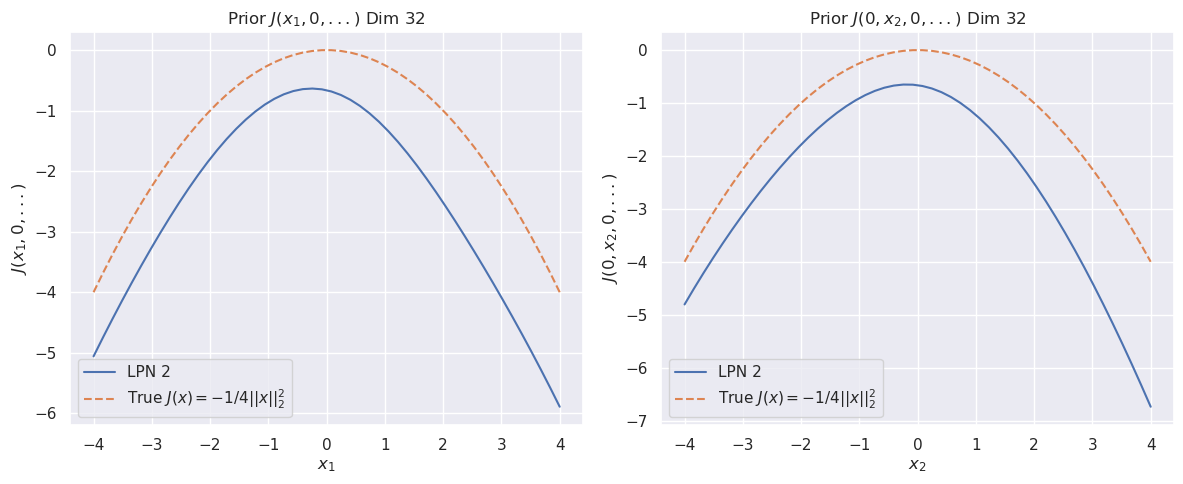

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)